# STEMMUS_SCOPE BMI demonstration

We first have to add the matlab runtime compiler locations to PATH:

In [1]:
import os
os.environ['LD_LIBRARY_PATH'] = (
    "/home/bart/matlab_runtime/R2023a/runtime/glnxa64:"
    "/home/bart/matlab_runtime/R2023a/bin/glnxa64:"
    "/home/bart/matlab_runtime/R2023a/sys/os/glnxa64:"
    "/home/bart/matlab_runtime/R2023a/extern/bin/glnxa64:"
    "/home/bart/matlab_runtime/R2023a/sys/opengl/lib/glnxa64"
)

Now we can initialize the model with a prepared configuration file:

In [2]:
from PyStemmusScope.bmi import StemmusScopeBmi
from cftime import num2pydate
from rich import print
import numpy as np
import xarray as xr

model = StemmusScopeBmi()

model.initialize("/home/bart/tmp/stemmus_scope/input/ZA-Kru_2023-11-16-0728/ZA-Kru_2023-11-16-0728_config.txt")

The model has the following input and output variables exposed:

In [3]:
print(model.get_input_var_names())
print(model.get_output_var_names())

('soil_temperature',)

('soil_temperature', 'respiration')

We can update the model and request the data for the respiration:

In [4]:
model.update()

dest = np.array([0.])
model.get_value("respiration", dest)

print(dest)

[3.6085965]

We can also request the value of variables at a certain index:

In [5]:
dest = np.zeros(1)
model.get_value_at_indices("soil_temperature", dest, inds=np.array([0]))

array([22.74423625])

To know at what coordinate in space this is, we can use the grid info functionality.

Grid `z` is depth in this case (grid 1 is the soil layer grid)

In [6]:
z = np.zeros(model.get_grid_size(1))
model.get_grid_z(1, z)
print(z[0])

-5.0

As an example, we can retrieve the soil temperature for every time step.

To make it more interesting we set the temperature of a deeper soil layer to 50 deg C at time step 12:

In [7]:
data = []
time = []
i=0

while model.get_current_time() < model.get_end_time():
    # update the model
    model.update()

    # Retrieve the modelled soil temperature field
    dest = np.ones(model.get_grid_size(model.get_var_grid("soil_temperature")))
    model.get_value("soil_temperature", dest)
    data.append(dest)

    # Store the current time as a datetime
    time.append(num2pydate(model.get_current_time(), model.get_time_units()))

    # Set some of the soil to 50 degrees C at time step 12.
    if i == 12:
        model.set_value_at_indices(
            "soil_temperature",
            inds=np.array([10, 11, 12]),
            src=np.array([50, 50, 50])
        )

    i+=1


In [8]:
gs = model.get_grid_size(1)
depths = np.ones(gs)
model.get_grid_z(1, depths)

da = xr.DataArray(
    data=np.vstack(data),
    dims=("time", "depth"),
    coords={"time": np.array(time), "depth": depths},
)

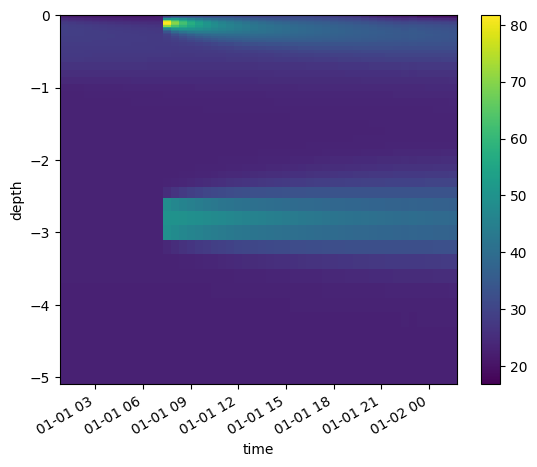

In [9]:
da.plot(y="depth")

It is important to call `finalize()` on the model when you're done, otherwise the model will stay running in the background:

In [10]:
model.finalize()